In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as cm
from scipy.integrate import cumulative_trapezoid, quad, trapezoid
from scipy import integrate
from scipy.interpolate import interp1d
from chainconsumer import Chain, ChainConsumer
import scipy.special as sc
from prettytable import PrettyTable
from IPython.display import display, Math
import corner
from tqdm.auto import tqdm
import time

## Corrected Luminosity distance function


In [159]:
def d_L(h, z, o_m, o_l, o_k=None, **kwargs):
    
    o_r = 9.e-5
    if o_k is None:
        o_k = 1 - o_m - o_l - o_r
    elif o_k == 0:
        o_l = 1 - o_m - o_r

    w = kwargs.get('w', None)

    # Hubble distance
    d_H = 2997.92458/h
    
    # Comoving Distance
    if w == None:
        d_C = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4  )
        d_C = cumulative_trapezoid(d_C(o_m, o_l, o_k), z, initial=0)
    else:
        d_C = lambda omega_m, omega_lambda, omega_k, w, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda * (1 + z) ** (3 * (1 + w)) + omega_r * (1+z)**4)
        d_C = cumulative_trapezoid(d_C(o_m, o_l, o_k, w), z, initial=0)

     
    d_C[np.isnan(d_C)] = 0
    
    # Transverse comoving distance:
    omega_k = o_k
    if omega_k > 0:
        d_M = d_H * (1/np.sqrt(omega_k)) * np.sinh((np.sqrt(omega_k) * d_C) / d_H) 

    if omega_k == 0:
        d_M = d_C

    if omega_k < 0:
        d_M = d_H * (1/np.sqrt(-omega_k)) * np.sin((np.sqrt(-omega_k) * d_C) / d_H) 

    # Luminosity Distance
    d_L = (1 + z) * d_M

    #if d_L[0] == 0.0:
    #    d_L = np.delete(d_L, 0)  #### REMOVE FIRST ELEMENT 0 FROM THE RESULT

    return d_L

#### Checks

In [149]:
h = 0.7
z = np.linspace(0, 2, 10000)
dl = d_L(h, z, 0.3, 0.7, 0, w = 5)
dl

array([0.00000000e+00, 8.56228785e-01, 1.71164408e+00, ...,
       1.79833331e+03, 1.79845338e+03, 1.79857345e+03])

In [150]:
func_dl= interp1d(z, dl) 
func_dl(0.9)

array(1132.1231263)

## Corrected Distance Modulus

In [160]:
def distance_modulus(h, z, omega_m, omega_l, omega_k=None, **kwargs):
    w = kwargs.get('w', None)

    dl = d_L(h, z, omega_m, omega_l, omega_k, w=w)
    #print('dl', dl)
    dis_mod = 5 * np.log10(dl) + 25
    #plt.plot(z, dis_mod)
    ####dis_mod = np.delete(dis_mod, 0)
    #print(z)
    #print(dis_mod.shape)
    return dis_mod

#### Checks

In [156]:
distance_modulus(h, z, 0.6, 0.3)

None


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_10999/2079992456.py:6: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25


array([       -inf, 24.66419757, 26.16956459, ..., 45.51965648,
       45.51991158, 45.52016666])

## Supernova Dataset

In [73]:
df = pd.read_csv("SCPUnion2_mu_vs_z.txt", sep="\t", header=None, names=["object_name", "redshift", "magnitude", "error_magnitude"], skiprows=5)
df

object_name  redshift  magnitude  error_magnitude
0        1993ah  0.028488  35.335551         0.226144
1        1993ag  0.050043  36.675442         0.167114
2         1993o  0.052926  36.816881         0.155866
3         1993b  0.070086  37.440321         0.158669
4        1992bs  0.062668  37.480331         0.156270
..          ...       ...        ...              ...
552      2001gn  1.124000  44.576403         0.198691
553      2001go  0.552000  42.530251         0.105933
554      2001gq  0.671000  42.991417         0.121927
555      2001gy  0.511000  42.388163         0.089912
556      2001hb  1.030000  44.251656         0.142161

[557 rows x 4 columns]

### Figure 7.5

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_10999/864007499.py:4: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25


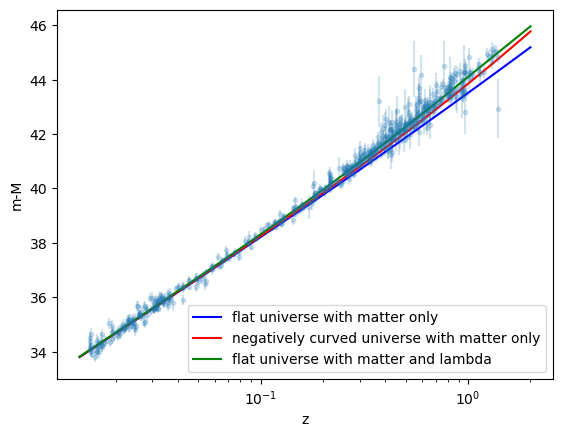

In [105]:
plt.errorbar(df['redshift'], df['magnitude'], yerr=df['error_magnitude'], fmt='.', alpha=0.2)
plt.xscale('log')
plt.xlabel("z")
plt.ylabel("m-M")


z_array = df['redshift'].to_numpy()
#print('Redshifts:', z_array)
x = np.linspace(0, 2, 150)
#x0 = np.delete(x, 0)

#log_x = np.log(x)

flat_matter = distance_modulus(h, x, 0.99, 0)
neg_curve_matter = distance_modulus(h, x, 0.3, 0)
flat_matter_cosmo = distance_modulus(h, x, 0.3, 0.69)

# Interpolation

func_flat_matter = interp1d(x, flat_matter)
func_neg_curve_matter = interp1d(x, neg_curve_matter)
func_flat_matter_cosmo = interp1d(x, flat_matter_cosmo)

####x = np.delete(x,0)

plt.plot(x, flat_matter, '-b',label='flat universe with matter only')

plt.plot(x, neg_curve_matter, '-r', label='negatively curved universe with matter only')

plt.plot(x, flat_matter_cosmo, '-g' ,label='flat universe with matter and lambda')
plt.legend()
plt.show()
#plt.legend(loc="upper left")



Goodness of fit for 3 models

In [75]:
'''
df['m-M_flat_matter'] = distance_modulus(df['redshift'], 0.99, 0)
#print(df['m-M_flat_matter'])
df['m-M_neg_curve_matter'] = distance_modulus(df['redshift'], 0.3, 0)

df['m-M_flat_matter_cosmo'] = distance_modulus(df['redshift'], 0.3, 0.69)
'''

df['m-M_flat_matter'] = func_flat_matter(df['redshift'])
#print(df['m-M_flat_matter'])

df['m-M_neg_curve_matter'] = func_neg_curve_matter(df['redshift'])

df['m-M_flat_matter_cosmo'] = func_flat_matter_cosmo(df['redshift'])


In [76]:
def chi_square(y_model, y, yerr):
    p = (y - y_model)**2/(yerr)**2
    return p


chi2_flat_matter = chi_square(df['m-M_flat_matter'], df['magnitude'], df['error_magnitude'])
chi2_neg_curve_matter = chi_square(df['m-M_neg_curve_matter'], df['magnitude'], df['error_magnitude'])
chi2_flat_matter_cosmo = chi_square(df['m-M_flat_matter_cosmo'], df['magnitude'], df['error_magnitude'])

print('$\chi^2$ for a flat universe with matter = ', chi2_flat_matter.sum())
print('$\chi^2$ for a negatively curved universe with matter = ', chi2_neg_curve_matter.sum())
print('$\chi^2$ for a flat universe with matter and cosmological constant = ', chi2_flat_matter_cosmo.sum())

$\chi^2$ for a flat universe with matter =  2078.838395228832
$\chi^2$ for a negatively curved universe with matter =  1036.7092988150268
$\chi^2$ for a flat universe with matter and cosmological constant =  568.6864177071203


In [77]:
# Chi Square Probability
'''
nu = len(df.index) - 6

chi_prob_flat_matter = sc.gammainc(0.5 * nu, 0.5 * chi2_flat_matter.sum())
chi_prob_neg_curve_matter = sc.gammainc(0.5 * nu, 0.5 * chi2_neg_curve_matter.sum())
chi_prob_flat_matter_cosmo = sc.gammainc(0.5 * nu, 0.5 * chi2_flat_matter_cosmo.sum())

print('chi2 probability for a flat universe with matter = ', chi_prob_flat_matter)
print('chi2 probability for a negatively curved universe with matter = ', chi_prob_neg_curve_matter)
print('chi2 probability for a flat universe with matter and cosmological matter = ', chi_prob_flat_matter_cosmo)'''


"\nnu = len(df.index) - 6\n\nchi_prob_flat_matter = sc.gammainc(0.5 * nu, 0.5 * chi2_flat_matter.sum())\nchi_prob_neg_curve_matter = sc.gammainc(0.5 * nu, 0.5 * chi2_neg_curve_matter.sum())\nchi_prob_flat_matter_cosmo = sc.gammainc(0.5 * nu, 0.5 * chi2_flat_matter_cosmo.sum())\n\nprint('chi2 probability for a flat universe with matter = ', chi_prob_flat_matter)\nprint('chi2 probability for a negatively curved universe with matter = ', chi_prob_neg_curve_matter)\nprint('chi2 probability for a flat universe with matter and cosmological matter = ', chi_prob_flat_matter_cosmo)"

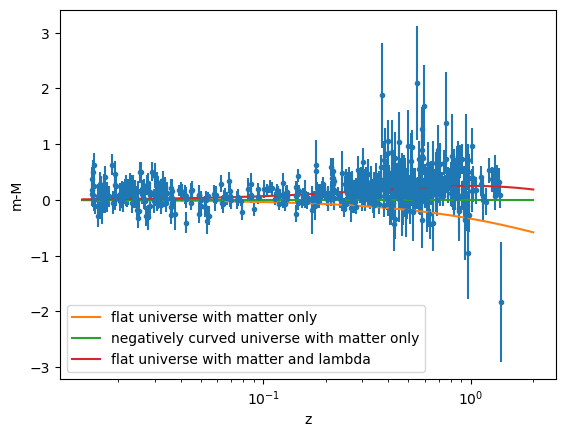

In [78]:
df['delta_dis_mod'] = df['magnitude'] - df['m-M_neg_curve_matter']

df['delta_m-M_flat_matter'] = df['m-M_flat_matter'] - df['m-M_neg_curve_matter']
df['delta_m-M_neg_curve_matter'] = df['m-M_neg_curve_matter'] - df['m-M_neg_curve_matter']
df['delta_m-M_flat_matter_cosmo'] = df['m-M_flat_matter_cosmo'] - df['m-M_neg_curve_matter']

plt.errorbar(df['redshift'], df['delta_dis_mod'], yerr=df['error_magnitude'], fmt='.')

plt.xscale('log')
plt.xlabel("z")
plt.ylabel("m-M")



#x = np.linspace(0.001, 2, 150)

delta_flat_matter = flat_matter - neg_curve_matter
plt.plot(x0, delta_flat_matter, label='flat universe with matter only')

delta_neg_curve_matter = neg_curve_matter - neg_curve_matter
plt.plot(x0, delta_neg_curve_matter, label='negatively curved universe with matter only')

delta_flat_matter_cosmo = flat_matter_cosmo - neg_curve_matter
plt.plot(x0, delta_flat_matter_cosmo, label='flat universe with matter and lambda')

plt.legend()


plt.show()

## Contour Plot for $\Omega_M$ and $\Omega_\Lambda$ (Figure 7.6)

In [79]:
def chi_square(y_model, y, yerr):
    p = (y - y_model)**2/(yerr)**2
    return p


### For Flat universe

In [84]:
nx = 1000

x = np.linspace(0.02, 0.535, nx) # omega_m

saveposteriors = np.zeros(nx)

z = np.linspace(0, 2, 1000)
z0 = np.delete(z, 0)

z_array = df['redshift'].to_numpy()
mag_array =  df['magnitude'].to_numpy()
mag_err = df['error_magnitude'].to_numpy()


for i in range(nx):
    model1 = distance_modulus(h, z, x[i],0, 0)
    func_model1 = interp1d(z0, model1)
    model2 = func_model1(z_array)
    post = chi_square(model2, mag_array, mag_err)
    saveposteriors[i] = np.sum(post) 

lp = saveposteriors - saveposteriors.min()
'''
lw = 1  # Line widths throughout the plot
fsz = 16  # Font size throughout the plot

# Square figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')


# Contour and labels
cs = ax.contour(x, y, lp, colors='k', linewidths=lw, levels= [1.00, 4.00, 9.00])#[2.30, 6.17, 11.8])
plt.clabel(cs, fontsize=fsz)


plt.xlabel(r'$\Omega_M$')
plt.ylabel(r"$\Omega_\Lambda$")
plt.title(r'$\chi^2 - \chi^2_{min}$')'''

'\nlw = 1  # Line widths throughout the plot\nfsz = 16  # Font size throughout the plot\n\n# Square figure\nfig = plt.figure()\nax = fig.add_subplot(111)\nax.set_aspect(\'equal\')\n\n\n# Contour and labels\ncs = ax.contour(x, y, lp, colors=\'k\', linewidths=lw, levels= [1.00, 4.00, 9.00])#[2.30, 6.17, 11.8])\nplt.clabel(cs, fontsize=fsz)\n\n\nplt.xlabel(r\'$\\Omega_M$\')\nplt.ylabel(r"$\\Omega_\\Lambda$")\nplt.title(r\'$\\chi^2 - \\chi^2_{min}$\')'

In [85]:
'''print(lp.shape)
ind = np.unravel_index(np.argmin(lp, axis=None), lp.shape)
print(ind)

print('Omega_m = ', xv[ind])
print('Omega_lambda = ', yv[ind])'''

"print(lp.shape)\nind = np.unravel_index(np.argmin(lp, axis=None), lp.shape)\nprint(ind)\n\nprint('Omega_m = ', xv[ind])\nprint('Omega_lambda = ', yv[ind])"

In [86]:
# Likelihood
lp1 = np.exp(-(saveposteriors - saveposteriors.min())/2)
'''
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_aspect('equal')

cs1 = ax1.contour(x, y, lp1, colors='k', linewidths=lw, levels=[np.exp(-9/2),  np.exp(-4/2),  np.exp(-1/2) ])#levels=[0.683, 0.954, 0.9973])
plt.clabel(cs1, fontsize=fsz)

plt.xlabel(r'$\Omega_M$')
plt.ylabel(r"$\Omega_\Lambda$")
plt.title('Likelihood')

# Add custom labels to the contours
fmt = {}
strs = ['99% ', '95% ', '68% ']
for l, s in zip(cs1.levels, strs):
    fmt[l] = s

# Label every other level using strings
#ax1.clabel(cs1, cs1.levels[::2], inline=True, fmt=fmt, fontsize=10)'''


'\nfig1 = plt.figure()\nax1 = fig1.add_subplot(111)\nax1.set_aspect(\'equal\')\n\ncs1 = ax1.contour(x, y, lp1, colors=\'k\', linewidths=lw, levels=[np.exp(-9/2),  np.exp(-4/2),  np.exp(-1/2) ])#levels=[0.683, 0.954, 0.9973])\nplt.clabel(cs1, fontsize=fsz)\n\nplt.xlabel(r\'$\\Omega_M$\')\nplt.ylabel(r"$\\Omega_\\Lambda$")\nplt.title(\'Likelihood\')\n\n# Add custom labels to the contours\nfmt = {}\nstrs = [\'99% \', \'95% \', \'68% \']\nfor l, s in zip(cs1.levels, strs):\n    fmt[l] = s\n\n# Label every other level using strings\n#ax1.clabel(cs1, cs1.levels[::2], inline=True, fmt=fmt, fontsize=10)'

Results from paper: 


<IPython.core.display.Math object>

<IPython.core.display.Math object>

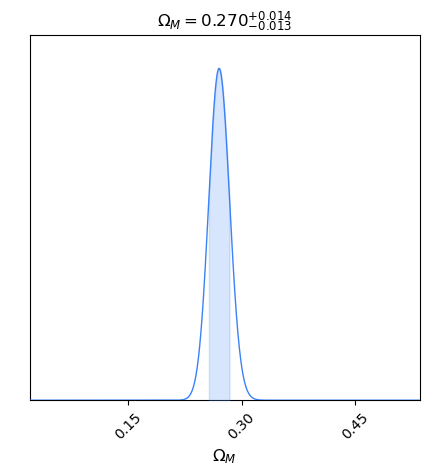

In [87]:
df1 = pd.DataFrame({"$\Omega_M$": x, "weight": lp1})
#df1 = pd.DataFrame({"$\Omega_M$": xv.flatten(), "$\Omega_\Lambda$": yv.flatten(), "weight": lp1.flatten()})

c = ChainConsumer()
c.add_chain(Chain(samples=df1, grid=True, name="Grid Data"))
fig = c.plotter.plot()

## Results from Paper
print('Results from paper: ')
display(Math(r'\Omega_k = 0 (fixed)'))
display(Math(r'\Omega_M = 0.277^{{+0.022}}_{{-0.021}} \\ \Omega_\Lambda = 0.729^{{+0.014}}_{{-0.014}}  ') )


### Save Results ###
df1.to_csv("omega_m-flat_universe_Grid_Sampling.csv", index=False)

In [39]:
### Check Likelihood for the results
o_m = 0.286
o_l = 0.7
h = 0.7
z = np.linspace(0, 2, 1000)
model1 = distance_modulus(h, z, o_m, o_l)
func_model1 = interp1d(z0, model1)
z0 = np.delete(z, 0)
model2 = func_model1(z_array)
chi2 = np.sum(chi_square(model2, mag_array, mag_err))
like = np.exp(-chi2/2)
chi2


545.5538031173485

In [40]:
dof = 557 - 1
reduced_chi2 = chi2/dof
reduced_chi2

0.981211876110339

### For curved universe

In [41]:
nx, ny = (200, 200)

x = np.linspace(0.02, 0.535, nx) # omega_m
y = np.linspace(0.42, 1.05, ny)  # omega_lambda

xv, yv = np.meshgrid(x, y, indexing='xy')

saveposteriors = np.zeros((nx, ny))

z = np.linspace(0, 2, 1000)
z0 = np.delete(z, 0)

z_array = df['redshift'].to_numpy()
mag_array =  df['magnitude'].to_numpy()
mag_err = df['error_magnitude'].to_numpy()


for i in range(nx):
    for j in range(ny):
        model1 = distance_modulus(h, z, xv[i, j], yv[i, j])
        func_model1 = interp1d(z0, model1)
        model2 = func_model1(z_array)
        post = chi_square(model2, mag_array, mag_err)
        saveposteriors[i][j] = np.sum(post) 

lp = saveposteriors - saveposteriors.min()


In [42]:
# Likelihood
lp1 = np.exp(-(saveposteriors - saveposteriors.min())/2)

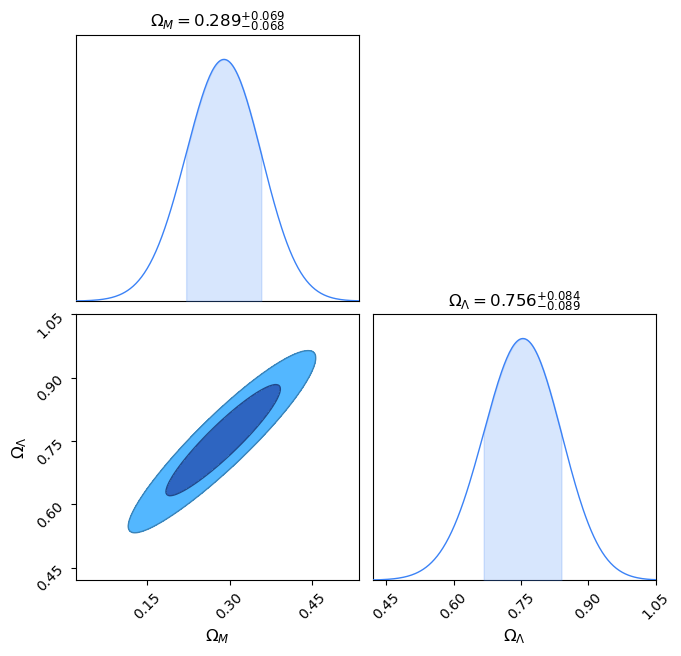

In [46]:
df2 = pd.DataFrame({"$\Omega_M$": xv.flatten(), "$\Omega_\Lambda$": yv.flatten(), "weight": lp1.flatten()})

c = ChainConsumer()
c.add_chain(Chain(samples=df2, grid=True, name="Grid Data"))
fig = c.plotter.plot()



### Save Results ###
df2.to_csv("omega_m_omega_l-curved_universe_Grid_Sampling.csv", index=False)

In [25]:
'''print(lp1.shape)
ind1 = np.unravel_index(np.argmax(lp1, axis=None), lp1.shape)
print(ind1)

print('Omega_m =', xv[ind1])
print('Omega_lambda =', yv[ind1])
print('P_max =', lp[ind1])
'''

"print(lp1.shape)\nind1 = np.unravel_index(np.argmax(lp1, axis=None), lp1.shape)\nprint(ind1)\n\nprint('Omega_m =', xv[ind1])\nprint('Omega_lambda =', yv[ind1])\nprint('P_max =', lp[ind1])\n"

In [26]:
'''# Extract contour levels and data points
contour_data = {}

T1, T2 = PrettyTable(), PrettyTable()
T1.field_names = ["Mean Value", "CI", "Error bars"]
T2.field_names = ["Mean Value", "CI", "Error bars"]

levels = ['99% ', '95% ', '68% ']
for i, level in enumerate(cs1.levels):
    #print(i, level)
    # Retrieve the paths for the current level
    paths = cs1.collections[i].get_paths()
    # Store contour level and its vertices
    #if i == 0:
    vertices_list = []
    omega_M = []
    omega_L = []
    for path in paths:
        vertices = path.vertices
        #print(level, vertices)
        for j in vertices:
            omega_M.append(j[0])
            omega_L.append(j[-1])
        #vertices_list.append(vertices)
        #omega_M.append(vertices[0])
        #omega_L.append(vertices[1])

    #print(i, level, 'min', np.min(omega_M), 'max' , np.max(omega_M))
    
    #For Omega_M
    #T1.add_row([xv[ind1], '[', np.min(omega_M), ',', np.max(omega_M), '], "Wonderland"])

    if i == 2:
        print(levels[i], ': \n Omega_M =', xv[ind1], '\n CI: [', np.min(omega_M), ',', np.max(omega_M), '] \n', xv[ind1], '+', np.max(omega_M)-xv[ind1], '-', xv[ind1] - np.min(omega_M), '\n\n'
           'Omega_L =', yv[ind1], '\n CI: [', np.min(omega_L), ',', np.max(omega_L), '] \n', yv[ind1], '+', np.max(omega_L)-yv[ind1], '-', yv[ind1] - np.min(omega_L), '\n')
        
        a = np.max(omega_M)-xv[ind1]
        b = xv[ind1] - np.min(omega_M)
        c = np.max(omega_L)-yv[ind1]
        d = yv[ind1] - np.min(omega_L)
        display(Math(r'\Omega_M = {:.5f}^{{+{}}}_{{-{}}} \\ \\ \\ \Omega_\Lambda = {:.5f}^{{+{}}}_{{-{}}}'.format(xv[ind1], {round(a,3)}, {round(b,3)}, yv[ind1], {round(c,3)}, {round(d, 3)})) )

    # Is the universe accelerating or decelerating?
    BF_Omega_M = xv[ind1]
    BF_Omega_Lambda = yv[ind1]
    Omega_Rad = 9.e-5
    q0 = Omega_Rad + 0.5 * BF_Omega_M - BF_Omega_Lambda

    if q0 < 0:
        print('The universe is accelerating! \n q0 =', q0)   
    elif q0>0:
        print('The universe is contracting! \n q0 =', q0) 

    #contour_data[level] = np.vstack(vertices_list)
    #display(Math(r'{}%: \\ \Omega_M ='.format(levels[i],)))
        
    #display(Math(r'Dims: {}x{}m \\ Area: {}m^2 \\ Volume: {}m^3'.format(a, round(b,2), P, V)))


'''


'''
for level, vertices in contour_data.items():
    plt.plot(vertices[:, 0], vertices[:, 1], label=f'Contour Level: {level}')

plt.legend()
#plt.show()
#print(contour_data.keys())


# Print the extracted contour values
for level, vertices in contour_data.items():
    #print(f'Contour Level: {level}')
    #print(f'Number of Points: {len(vertices)}')
    #print(f'Points:\n{vertices}\n')
    if level == 0.3166367693790533:
        Omega_M = vertices[:, 0]
        Omega_Lambda = vertices[:, 1]
        print(vertices)

#print(Omega_M)
smallest_M = np.min(Omega_M)
largest_M = np.max(Omega_M)

smallest_L = np.min(Omega_Lambda)
largest_L = np.max(Omega_Lambda)

#print(smallest_L)
#print(f'68.3$%$ limits: \n $Omega_M$: ', xv[ind1], f'',-smallest_M , '$\pm$', xv[ind1]+largest_M, '\n $Omega_\Lambda$:', yv[ind1]-smallest_L, '$\pm$', yv[ind1]+largest_M )
#print('errs',max(Omega_M), min(Omega_M))
'''

"\nfor level, vertices in contour_data.items():\n    plt.plot(vertices[:, 0], vertices[:, 1], label=f'Contour Level: {level}')\n\nplt.legend()\n#plt.show()\n#print(contour_data.keys())\n\n\n# Print the extracted contour values\nfor level, vertices in contour_data.items():\n    #print(f'Contour Level: {level}')\n    #print(f'Number of Points: {len(vertices)}')\n    #print(f'Points:\n{vertices}\n')\n    if level == 0.3166367693790533:\n        Omega_M = vertices[:, 0]\n        Omega_Lambda = vertices[:, 1]\n        print(vertices)\n\n#print(Omega_M)\nsmallest_M = np.min(Omega_M)\nlargest_M = np.max(Omega_M)\n\nsmallest_L = np.min(Omega_Lambda)\nlargest_L = np.max(Omega_Lambda)\n\n#print(smallest_L)\n#print(f'68.3$%$ limits: \n $Omega_M$: ', xv[ind1], f'',-smallest_M , '$\\pm$', xv[ind1]+largest_M, '\n $Omega_\\Lambda$:', yv[ind1]-smallest_L, '$\\pm$', yv[ind1]+largest_M )\n#print('errs',max(Omega_M), min(Omega_M))\n"

# 3 parameters

In [47]:
nx, ny, nh = (200, 200, 200)

x = np.linspace(0.02, 0.535, nx) # omega_m
y = np.linspace(0.42, 1.05, ny)  # omega_lambda
h = np.linspace(0.65, 0.75, nh)   # H0

xv, yv, hv = np.meshgrid(x, y, h, indexing='xy')

saveposteriors_3d = np.zeros((nx, ny, nh))

z = np.linspace(0, 2, 1000)
z0 = np.delete(z, 0)

z_array = df['redshift'].to_numpy()
mag_array =  df['magnitude'].to_numpy()
mag_err = df['error_magnitude'].to_numpy()

for i in range(nx):
    for j in range(ny):
        for k in range(nh):
            model1 = distance_modulus(hv[i, j, k], z, xv[i, j, k], yv[i, j, k])
            func_model1 = interp1d(z0, model1)
            model2 = func_model1(z_array)
            post = chi_square(model2, mag_array, mag_err)
            saveposteriors_3d[i][j][k] = np.sum(post)

lp_3d = saveposteriors_3d - saveposteriors_3d.min()

In [48]:
#print(lp_3d)

In [49]:
# Likelihood
#lp1 = np.exp(-(saveposteriors - saveposteriors.min())/2)
#lp1 = np.exp(-(saveposteriors - saveposteriors.min())/2)
lp1_3d = np.exp(-lp_3d/2)
#print(lp1_3d)
#print(lp1.shape)
'''
for i in lp1:
    for j in i:
        for k in j:
            if k ==0:
                print(k)'''




'\nfor i in lp1:\n    for j in i:\n        for k in j:\n            if k ==0:\n                print(k)'

         $\Omega_M$  $\Omega_\Lambda$         h        weight
0             0.020              0.42  0.650000  3.654494e-94
1             0.020              0.42  0.650503  3.723509e-92
2             0.020              0.42  0.651005  3.589738e-90
3             0.020              0.42  0.651508  3.275009e-88
4             0.020              0.42  0.652010  2.827847e-86
...             ...               ...       ...           ...
7999995       0.535              1.05  0.747990  7.081290e-77
7999996       0.535              1.05  0.748492  1.829954e-78
7999997       0.535              1.05  0.748995  4.558956e-80
7999998       0.535              1.05  0.749497  1.095016e-81
7999999       0.535              1.05  0.750000  2.535936e-83

[8000000 rows x 4 columns]


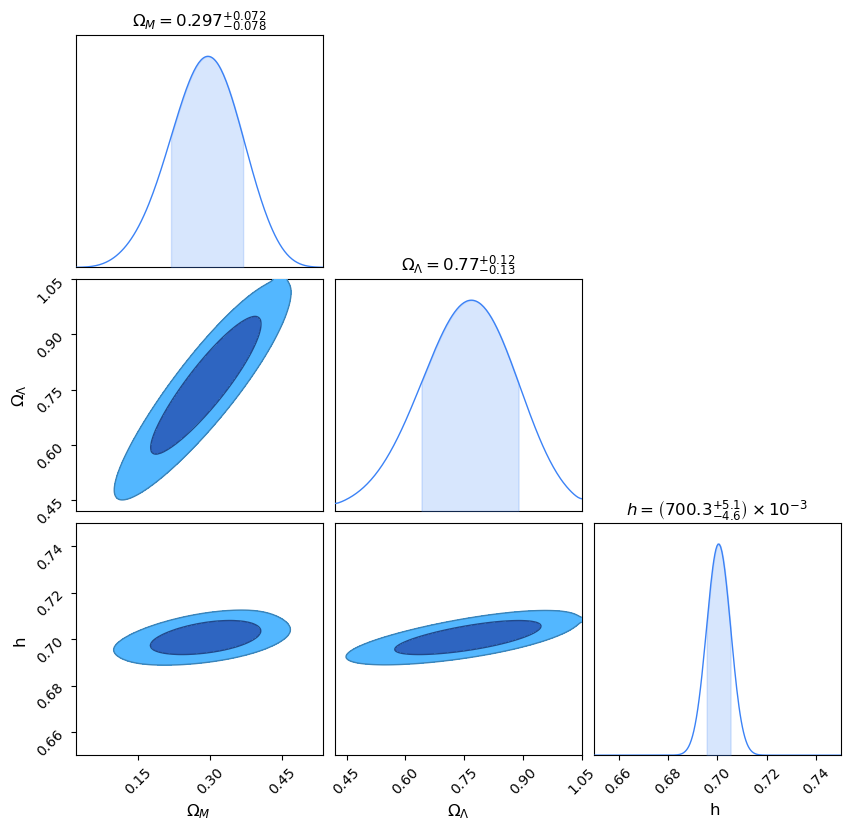

In [59]:
df1_3d = pd.DataFrame({"$\Omega_M$": xv.flatten(), "$\Omega_\Lambda$": yv.flatten(), "h": hv.flatten(), "weight": lp1_3d.flatten()})
print(df1_3d)
epsilon = 1e-10
df1_3d["weight"] = df1_3d["weight"].replace(0, epsilon)

c = ChainConsumer()
c.add_chain(Chain(samples=df1_3d, grid=True, name="Grid Data"))
fig = c.plotter.plot()

## Results from Paper
#print('Results from paper: ')
#display(Math(r'\Omega_k = 0 (fixed)'))
#display(Math(r'\Omega_M = 0.277^{{+0.022}}_{{-0.021}} \\ \Omega_\Lambda = 0.729^{{+0.014}}_{{-0.014}}  ') )

In [60]:
### Save Results ###
df1_3d.to_csv("h_omega_m_omega_l-curved_universe_Grid_Sampling.csv", index=False)

In [52]:
### Check Likelihood for the results
o_m = 0.297
o_l = 0.77
h = 0.7003
z = np.linspace(0, 2, 1000)
model1 = distance_modulus(h, z, o_m, o_l)
func_model1 = interp1d(z0, model1)
z0 = np.delete(z, 0)
model2 = func_model1(z_array)
chi2 = np.sum(chi_square(model2, mag_array, mag_err))
like = np.exp(-chi2/2)
chi2


542.904351904371

In [53]:
dof = 557 - 3
reduced_chi2 = chi2/dof
reduced_chi2

0.9799717543400198

## Marginalization

In [54]:
def likelihood(h, z, om_m, mag_array, mag_err, z_array):
    """ Flat universe """
    # Marginalize over H0
    
    om_k = 0
    om_r = 9.e-5
    om_l = 1 - om_m - om_r - om_k

    d_H = 2997.92458/h
    A = 5 * np.log10(d_H)
    #dA = - 5 / (np.log(10) * h)

    int1 = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : 1/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4 )
    int1 = cumulative_trapezoid(int1(om_m, om_l, om_k), z, initial=0)
    func = interp1d(z, int1)
    int1 = func(z_array)

    B = (5 * np.log10((1 + z_array) * int1)) + 25

    f1 = - 0.5 * np.sum(1 / (mag_err ** 2))
    f2 = - np.sum((B - mag_array) / (mag_err ** 2))
    f3 = - 0.5 * np.sum(((B - mag_array) ** 2 )/ (mag_err ** 2))

    #print(f1, f2, f3)
    
    #integrand = lambda f1, f2, f3, A, dA: dA * np.exp(f3 + (f1 * (A + (f2 / (2 * f1))) ** 2)) 
    integrand = lambda f1, f2, f3, A: np.exp(f3 + (A * f2) + (f1 * A * A))
       
    print(np.exp(f3 + (A * f2) + (f1 * A * A)))
    #print((f3 + (f1 * (A + f2 / (2 * f1)) ** 2)))
    #print(integrand(f1, f2, f3, A, dA))

    marginalized_likelihood = trapezoid(integrand(f1, f2, f3, A), h)#, initial=0)

    #marginalized_likelihood, _ = quad(integrand(f1, f2, f3, A, dA), 0.5, 1.0)
    
    
    return marginalized_likelihood

In [55]:
df = pd.read_csv("SCPUnion2_mu_vs_z.txt", sep="\t", header=None, names=["object_name", "redshift", "magnitude", "error_magnitude"], skiprows=5)

nx = 200

x = np.linspace(0.02, 0.535, nx) # omega_m

saveposteriors = np.ones((nx))

z = np.linspace(0, 2, 1000)
z0 = np.delete(z, 0)

z_array = df['redshift'].to_numpy()
mag_array =  df['magnitude'].to_numpy()
mag_err = df['error_magnitude'].to_numpy()

h_array = np.linspace(0.68, 0.72, 1000)

for i in range(nx):
    saveposteriors[i] = likelihood(h_array, z, x[i], mag_array, mag_err, z_array)

saveposteriors = np.array(saveposteriors)
saveposteriors

[9.22467223e-308 1.41438331e-307 2.16791289e-307 3.32181222e-307
 5.08823196e-307 7.79143263e-307 1.19268665e-306 1.82513100e-306
 2.79203202e-306 4.26977944e-306 6.52753495e-306 9.97589138e-306
 1.52409832e-305 2.32773237e-305 3.55395500e-305 5.42437420e-305
 8.27649051e-305 1.26241367e-304 1.92493500e-304 2.93419779e-304
 4.47117494e-304 6.81103205e-304 1.03720164e-303 1.57896498e-303
 2.40292856e-303 3.65568109e-303 5.55974471e-303 8.45279875e-303
 1.28471076e-302 1.95195308e-302 2.96478079e-302 4.50168424e-302
 6.83308341e-302 1.03685420e-301 1.57281614e-301 2.38505033e-301
 3.61556762e-301 5.47917029e-301 8.30065771e-301 1.25709944e-300
 1.90320778e-300 2.88046263e-300 4.35810590e-300 6.59163013e-300
 9.96660901e-300 1.50647378e-299 2.27633054e-299 3.43849727e-299
 5.19232276e-299 7.83816388e-299 1.18284186e-298 1.78442680e-298
 2.69110428e-298 4.05715942e-298 6.11467532e-298 9.21264923e-298
 1.38757191e-297 2.08923032e-297 3.14468405e-297 4.73181348e-297
 7.11767484e-297 1.070307

array([1.53668012e-192, 3.27593763e-190, 6.05860694e-188, 9.75591133e-186,
       1.37254113e-183, 1.69272388e-181, 1.83582508e-179, 1.75625011e-177,
       1.48636202e-175, 1.11601585e-173, 7.45421846e-172, 4.44073884e-170,
       2.36550897e-168, 1.12945012e-166, 4.84511033e-165, 1.87163819e-163,
       6.52495609e-162, 2.05729670e-160, 5.87865854e-159, 1.52543511e-157,
       3.60156493e-156, 7.75167946e-155, 1.52374137e-153, 2.74044977e-152,
       4.51745399e-151, 6.83717354e-150, 9.51711170e-149, 1.22039610e-147,
       1.44401998e-146, 1.57914498e-145, 1.59859559e-144, 1.50040335e-143,
       1.30770806e-142, 1.06004697e-141, 8.00440260e-141, 5.63900319e-140,
       3.71218828e-139, 2.28719717e-138, 1.32106612e-137, 7.16484021e-137,
       3.65492027e-136, 1.75664612e-135, 7.96874916e-135, 3.41806543e-134,
       1.38886655e-133, 5.35619303e-133, 1.96431420e-132, 6.86407678e-132,
       2.28999873e-131, 7.30863162e-131, 2.23584229e-130, 6.56881390e-130,
       1.85685652e-129, 5

     $\Omega_M$         weight
0      0.020000  1.536680e-192
1      0.022588  3.275938e-190
2      0.025176  6.058607e-188
3      0.027764  9.755911e-186
4      0.030352  1.372541e-183
..          ...            ...
195    0.524648  7.130783e-149
196    0.527236  1.706685e-149
197    0.529824  4.015728e-150
198    0.532412  9.289865e-151
199    0.535000  2.113140e-151

[200 rows x 2 columns]
Results from paper: 


<IPython.core.display.Math object>

<IPython.core.display.Math object>

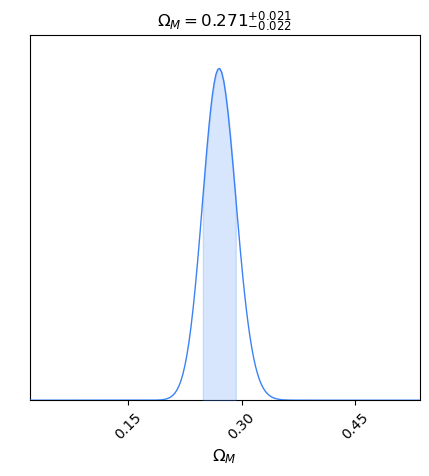

In [56]:
df2 = pd.DataFrame({"$\Omega_M$": x, "weight": saveposteriors})
print(df2)
epsilon = 1e-10
df2["weight"] = df2["weight"].replace(0, epsilon)

c1 = ChainConsumer()
c1.add_chain(Chain(samples=df2, grid=True, name="Analytical Marginalization", color = "blue"))
#c1.add_chain(Chain(samples=df1, grid=True, name="Manual Marginalization with single value", color = "red"))
#c1.configure(statistics="max", legend=True)

fig = c1.plotter.plot()

## Results from Paper
print('Results from paper: ')
display(Math(r'\Omega_k = 0 (fixed)'))
display(Math(r'\Omega_M = 0.277^{{+0.022}}_{{-0.021}} \\ \Omega_\Lambda = 0.729^{{+0.014}}_{{-0.014}}  ') )

In [107]:
### Save Results ###
df2.to_csv("omega_m_from_marginalization_Grid_Sampling.csv", index=False)


### Check Likelihood for the results
o_m = 0.271
o_l = 0.7
h = 0.7
z = np.linspace(0, 2, 1000)
model1 = distance_modulus(h, z, o_m, o_l)
func_model1 = interp1d(z, model1)
model2 = func_model1(z_array)
chi2 = np.sum(chi_square(model2, mag_array, mag_err))
like = np.exp(-chi2/2)
chi2

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_10999/864007499.py:4: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25


544.0846144171364

In [108]:
dof = 557 - 1
reduced_chi2 = chi2/dof
reduced_chi2

0.9785694503905331

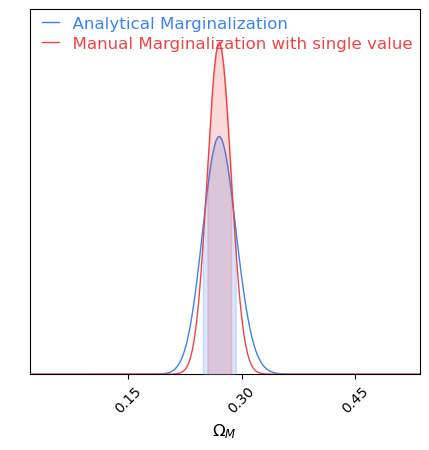

In [33]:
#### ANALYTIC MARGINALIZATION VS MANUAL MARGINALIZATION??? ####

c1 = ChainConsumer()
c1.add_chain(Chain(samples=df2, grid=True, name="Analytical Marginalization", color = "blue"))
c1.add_chain(Chain(samples=df1, grid=True, name="Manual Marginalization with single value", color = "red"))
#c1.configure(statistics="max", legend=True)
fig = c1.plotter.plot()


## $\omega$ vs $\Omega_M$

In [165]:
nx, nw = (200, 200)

x = np.linspace(0.02, 0.535, nx) # omega_m
w = np.linspace(-2, 0, nw)       # w parameter

xv, wv = np.meshgrid(x, w, indexing='xy')

saveposteriors = np.zeros((nx, nw))

z = np.linspace(0, 2, 1000)
#z0 = np.delete(z, 0)

z_array = df['redshift'].to_numpy()
mag_array =  df['magnitude'].to_numpy()
mag_err = df['error_magnitude'].to_numpy()


for i in range(nx):
    for j in range(nw):
        h = 0.7
        model1 = distance_modulus(h, z, xv[i, j], 0, 0, w=wv[i, j])
        func_model1 = interp1d(z, model1)
        model2 = func_model1(z_array)
        post = chi_square(model2, mag_array, mag_err)
        saveposteriors[i][j] = np.sum(post) 

lp = saveposteriors - saveposteriors.min()


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_10999/3883313537.py:6: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25


In [166]:
lp = np.exp(-lp/2)

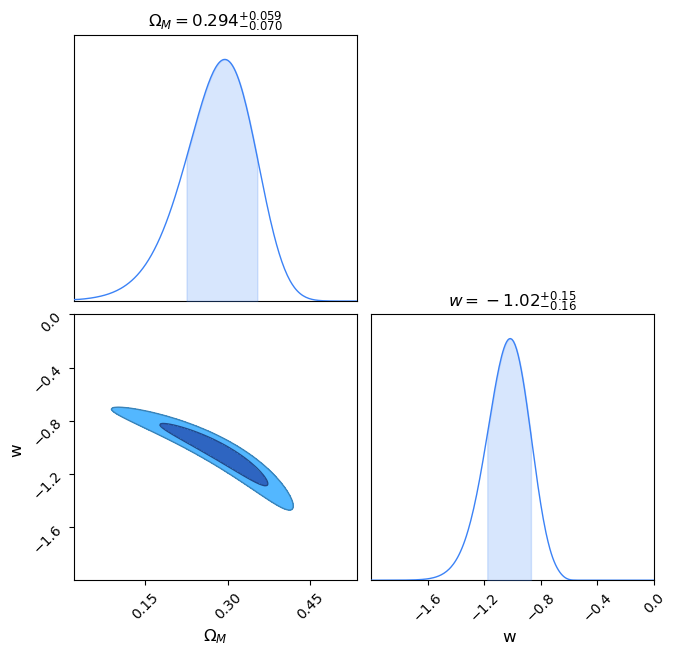

In [167]:
df1 = pd.DataFrame({"$\Omega_M$": xv.flatten(), "w": wv.flatten(), "weight": lp.flatten()})
epsilon = 1e-10
df1["weight"] = df1["weight"].replace(0, epsilon)

c = ChainConsumer()
c.add_chain(Chain(samples=df1, grid=True, name="Grid Data"))
fig = c.plotter.plot()


## $\omega$ vs $\Omega_M$ vs $\Omega_\Lambda$ 

In [169]:
nx, ny, nh = (200, 200, 200)

x = np.linspace(0.02, 0.535, nx) # omega_m
y = np.linspace(0.42, 1.05, ny)  # omega_lambda
w = np.linspace(-2, 0, nw)       # w parameter


xv, yv, wv = np.meshgrid(x, y, w, indexing='xy')

saveposteriors = np.zeros((nx, ny, nw))

z = np.linspace(0, 2, 1000)
z0 = np.delete(z, 0)

z_array = df['redshift'].to_numpy()
mag_array =  df['magnitude'].to_numpy()
mag_err = df['error_magnitude'].to_numpy()


for i in range(nx):
    for j in range(ny):
        for k in range(nw):
            model1 = distance_modulus(0.7, z, xv[i, j, k], yv[i, j, k], w=wv[i, j, k])
            func_model1 = interp1d(z, model1)
            model2 = func_model1(z_array)
            post = chi_square(model2, mag_array, mag_err)
            saveposteriors[i][j][k] = np.sum(post) 

lp = saveposteriors - saveposteriors.min()


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_10999/3883313537.py:6: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_10999/1449692587.py:19: RuntimeWarning: invalid value encountered in sqrt
  d_C = lambda omega_m, omega_lambda, omega_k, w, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda * (1 + z) ** (3 * (1 + w)) + omega_r * (1+z)**4)
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_10999/3883313537.py:6: RuntimeWarning: invalid value encountered in log10
  dis_mod = 5 * np.log10(dl) + 25


In [170]:
lp = np.exp(-lp/2)


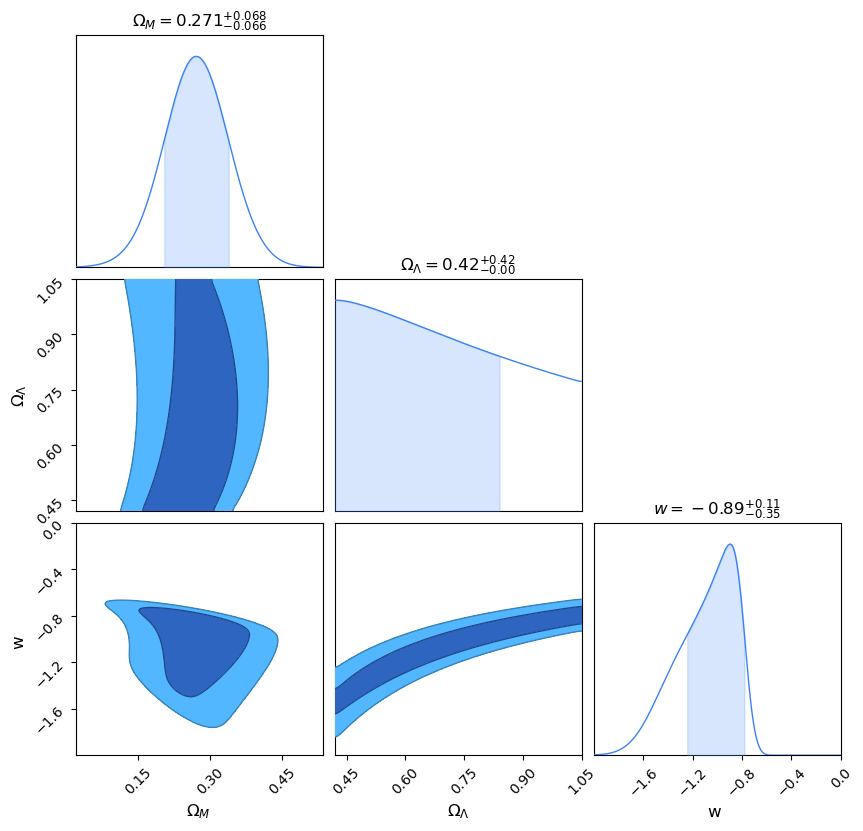

In [172]:
df1 = pd.DataFrame({"$\Omega_M$": xv.flatten(), "$\Omega_\Lambda$": yv.flatten(), "w": wv.flatten(), "weight": lp.flatten()})
epsilon = 1e-10
df1["weight"] = df1["weight"].replace(0, epsilon)

c = ChainConsumer()
c.add_chain(Chain(samples=df1, grid=True, name="Grid Data"))
fig = c.plotter.plot()


In [ ]:
# Log-likelihood with marginalization over H0
def log_likelihood(h, z, om_m, om_l, mu_obs, sigma_mu, h_prior_mean, h_prior_sigma):
    """Log-likelihood for supernova data with marginalized H0."""
    
    # Marginalize over H0
    def integrand(h):
        mu_model = distance_modulus(h, z, om_m, om_l)
        chi2 = np.sum(((mu_obs - mu_model) / sigma_mu)**2)
        log_prior_h = -0.5 * ((h - h_prior_mean) / h_prior_sigma)**2
        return np.exp(-0.5 * chi2 + log_prior_h)
    
    marginalized_likelihood, _ = quad(integrand, 0.5, 1)  # Marginalize H0 over a reasonable range
    return np.log(marginalized_likelihood)

In [120]:
def likelihood(h, z, om_m, om_l, om_k, mag_array, mag_err, z_array):

    # Marginalize over H0
    
    d_H = 2997.92458/h
    A = 5 * np.log10(d_H)
    dA = 5 / (np.log(10) * h)

    

    d_C = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4 )
    d_C = cumulative_trapezoid(d_C(om_m, om_l, om_k), z, initial=0)
    func = interp1d(z, d_C)
    d_C = func(z_array)

    B = 5 * np.log10((1 + z_array) * d_C) + 25

    f1 = - 0.5 * np.sum(1 / (mag_err ** 2))
    f2 = - np.sum((B - mag_array) / (mag_err ** 2))
    f3 = - 0.5 * np.sum((B - mag_array) ** 2 / (mag_err ** 2))
    
    integrand = lambda f1, f2, f3, A, dA: np.exp(f3 + (f1 * (A + f2 / (2 * f1)) ** 2)) * dA
       
    marginalized_likelihood = trapezoid(integrand(f1, f2, f3, A, dA), h)#, initial=0)

    #marginalized_likelihood, _ = quad(integrand(f1, f2, f3, A, dA), 0.5, 1.0)
    
    
    return marginalized_likelihood

In [121]:
o_m = 0.297
o_l = 0.77
o_k = 0
z = np.linspace(0, 2, 1000)
h = np.linspace(0.0, 1.0, 1000)

z_array = df['redshift'].to_numpy()
mag_array =  df['magnitude'].to_numpy()
mag_err = df['error_magnitude'].to_numpy()

mar_like = likelihood(h, z, o_m, o_l, o_k, mag_array, mag_err, z_array)
mar_like

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_93602/3810200281.py:5: RuntimeWarning: divide by zero encountered in divide
  d_H = 2997.92458/h
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_93602/3810200281.py:7: RuntimeWarning: divide by zero encountered in divide
  dA = 5 / (np.log(10) * h)
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_93602/3810200281.py:22: RuntimeWarning: invalid value encountered in multiply
  integrand = lambda f1, f2, f3, A, dA: np.exp(f3 + (f1 * (A + f2 / (2 * f1)) ** 2)) * dA


nan

In [137]:
# log_likelihood

o_m = 0.297
o_l = 0.77
o_k = 0

z = np.linspace(0, 2, 1000)
h = np.linspace(0.5, 0.8, 1000)

z_array = df['redshift'].to_numpy()
mag_array =  df['magnitude'].to_numpy()
mag_err = df['error_magnitude'].to_numpy()

d_H = 2997.92458/h
A = 5 * np.log10(d_H)
dA = -5 / (np.log(10) * h)

d_C = lambda omega_m, omega_lambda, omega_k, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + omega_k * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4 )
d_C = cumulative_trapezoid(d_C(o_m, o_l, o_k), z, initial=0)
func = interp1d(z, d_C)
d_C = func(z_array)

B = 5 * np.log10((1 + z_array) * d_C) + 25

f1 = - 0.5 * np.sum(1 / (mag_err ** 2))
f2 = - np.sum((B - mag_array) / (mag_err ** 2))
f3 = - 0.5 * np.sum((B - mag_array) ** 2 / (mag_err ** 2))

log_likelihood = lambda f1, f2, f3, A, dA: f3 + (f1 * (A + f2 / (2 * f1)) ** 2) * dA
log_likelihood = trapezoid(log_likelihood(f1, f2, f3, A, dA), h)


log_likelihood




3372586.820992835

In [131]:
df2 = pd.DataFrame({"$\Omega_M$": xv.flatten(), "$\Omega_\Lambda$": yv.flatten(), "weight": log_likelihood})
print(df2)
epsilon = 1e-10
df2["weight"] = df2["weight"].replace(0, epsilon)

c1 = ChainConsumer()
c1.add_chain(Chain(samples=df2, grid=True, name="Grid Data"))
fig = c1.plotter.plot()

ValueError: All arrays must be of the same length

In [210]:
df_data = pd.DataFrame()


#result, error = integrate.tplquad(f, xmin, xmax, lambda _: ymin, lambda _:ymax,lambda *_: zmin, lambda *_: zmax)


def frac_prob(a1, a2, b1, b2):
    total_prob, err1 = integrate.dblquad(lp1, x0, x1, y0, y1)#integrate the whole grid
    prob, err2 = integrate.dblquad(lp1, a1, a2, b1, b2)#integrate within limits from a1 to a2 for omega_m and b1 to b2 for omega_lambda
    return prob/total_prob

for i, j, k, l in zip(range(nx), range(ny), range(nx), range(ny)):
    #for k, l in zip(range(nx), range(ny)):
    if i != k and j != l:
        if lp1[i, j] == lp1[k, l]:
            a1 = xv[i, j]    # omega_m
            a2 = xv[k, l]
            b1 = yv[i, j]    # omega_lambda
            b2 = yv[k, l]
            if a1 < a2 and b1 < b2:
                print(a1, a2, b1, b2)
                frac = frac_prob(a1, a2, b1, b2)
                print(frac)
                if frac == 0.683:
                    print(f'68.3$%$ limits: \n $Omega_M$: ', xv[ind1]-a1 , '$\pm$', xv[ind1]+a2, '\n $Omega_\Lambda$:', yv[ind1]-b1, '$\pm$', yv[ind1]+b2 )

In [202]:
for item in cs1.collections:
   for i in item.get_paths():
      v = i.vertices
      x = v[:, 0]
      y = v[:, 1]
      print(x, y)

[0.34492935 0.34646465 0.34700906 0.35050505 0.35056317 0.35415504
 0.35454545 0.35770449 0.35858586 0.36119431 0.36262626 0.36461841
 0.36666667 0.36796972 0.37070707 0.37123997 0.37448334 0.37474747
 0.37775083 0.37878788 0.38092992 0.38282828 0.38400906 0.38686869
 0.38697476 0.39000563 0.39090909 0.39293886 0.39494949 0.39573907
 0.39847948 0.3989899  0.4011975  0.4030303  0.40375133 0.40623862
 0.40707071 0.40863391 0.41084521 0.41111111 0.41299435 0.4149112
 0.41515152 0.41668774 0.41818896 0.41919192 0.41939901 0.42016764
 0.42027497 0.41920839 0.41919192 0.41515152 0.41111111 0.40707071
 0.4030303  0.3989899  0.39674386 0.39494949 0.39090909 0.38817999
 0.38686869 0.38282828 0.38090876 0.37878788 0.37474747 0.37428323
 0.37070707 0.36810904 0.36666667 0.36262626 0.36223698 0.35858586
 0.35658516 0.35454545 0.3511586  0.35050505 0.34646465 0.34587252
 0.34242424 0.34069933 0.33838384 0.33567812 0.33434343 0.33078945
 0.33030303 0.32626263 0.32597624 0.32222222 0.32119815 0.31818

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_2734/1458624693.py:1: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for item in cs1.collections:


In [206]:
for item in cs1.collections:
   for i in item.get_paths():
      v = i.vertices
      x = v[:, 0]
      y = v[:, 1]
      #print(v)
      #print(x, y, '\n')

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_2734/3104154951.py:1: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for item in cs1.collections:


In [129]:
def center_of_mass(X):
    # calculate center of mass of a closed polygon
    x = X[:,0]
    y = X[:,1]
    g = (x[:-1]*y[1:] - x[1:]*y[:-1])
    A = 0.5*g.sum()
    cx = ((x[:-1] + x[1:])*g).sum()
    cy = ((y[:-1] + y[1:])*g).sum()
    return 1./(6*A)*np.array([cx,cy])


print(cs.allsegs[-1][0])
#c =  center_of_mass(cs1.allsegs[-1][0])
#print(c)




[0.14110133 0.65517219]


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_2734/1403911707.py:12: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  print(cs.allsegs[-1][0])


In [ ]:




fig, ax = plt.subplots()
ax.pcolormesh(X,Y,Z, cmap="Reds", vmax=10)

contour = ax.contour(X,Y,Z,levels=[1.01,1.1,1.2], colors="k")

c =  center_of_mass(contour.allsegs[-1][0])
ax.plot(c[0],c[1], marker="o", markersize=12, color="red")
plt.show()

In [99]:
nx, ny = (3, 3)
x = np.linspace(0, 1, nx)
y = np.linspace(2, 3, ny)
xv, yv = np.meshgrid(x, y, indexing='xy')
print(xv, yv)
for i in range(nx):
    for j in range(ny):
        print(i, j, xv[i,j])

[[0.  0.5 1. ]
 [0.  0.5 1. ]
 [0.  0.5 1. ]] [[2.  2.  2. ]
 [2.5 2.5 2.5]
 [3.  3.  3. ]]
0 0 0.0
0 1 0.5
0 2 1.0
1 0 0.0
1 1 0.5
1 2 1.0
2 0 0.0
2 1 0.5
2 2 1.0


In [472]:
#lp = np.exp(-(saveposteriors - saveposteriors.min()))



    Make a *sick* corner plot showing the projections of a data set in a
    multi-dimensional space. kwargs are passed to hist2d() or used for
    `matplotlib` styling.

    Parameters
    ----------
    data : obj
        Any object that can be converted to an ``arviz.InferenceData`` object.
        Refer to documentation of ``arviz.convert_to_dataset`` for details.

    bins : int or array_like[ndim,]
        The number of bins to use in histograms, either as a fixed value for
        all dimensions, or as a list of integers for each dimension.

    group : str
        Specifies which InferenceData group should be plotted.  Defaults to
        ``'posterior'``.

    var_names : list
        Variables to be plotted, if ``None`` all variable are plotted. Prefix
        the variables by `~` when you want to exclude them from the plot.

    filter_vars : {``None``, ``"like"``, ``"regex"``}
        If ``None`` (default), interpret ``var_names`` as the real variables
        names. If ``"

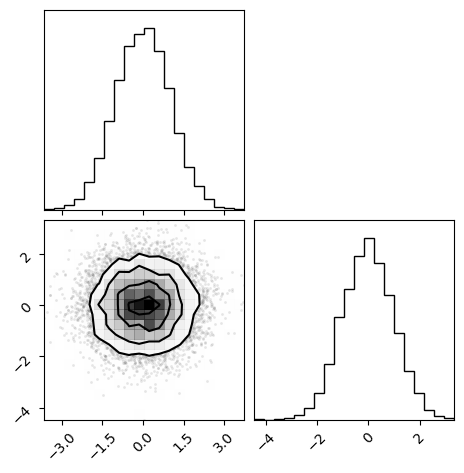

In [ ]:
#figure = corner.corner(saveposteriors)
print(corner.corner.__doc__)


print(saveposteriors.shape)

ndim, nsamples = 2, 10000
np.random.seed(42)
print(np.random.randn(ndim * nsamples).shape)
samples = np.random.randn(ndim * nsamples).reshape([nsamples, ndim])
print(samples.shape)
figure = corner.corner(samples)

In [40]:
z = np.linspace(0, 0.3735, 20)
print(z)

print(distance_modulus(h, z, 0.18181818181818182, 2.272727272727273))

#d_H * (1/np.sqrt(omega_k)) * np.sin((np.sqrt(omega_k) * d_C) / d_H) 


[0.         0.01965789 0.03931579 0.05897368 0.07863158 0.09828947
 0.11794737 0.13760526 0.15726316 0.17692105 0.19657895 0.21623684
 0.23589474 0.25555263 0.27521053 0.29486842 0.31452632 0.33418421
 0.35384211 0.3735    ]
[34.69454416 36.26757947 37.21603297 37.90896461 38.46213874 38.92722197
 39.33188076 39.69274546 40.02067603 40.32324747 40.606064   40.87353031
 41.12936594 41.37702673 41.62018477 41.86355162 42.115009   42.39489626
        -inf]


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_2734/1664162530.py:27: RuntimeWarning: invalid value encountered in sqrt
  d_C = lambda omega_m, omega_lambda, omega_r=9.e-5 : d_H/np.sqrt(omega_m * (1 + z)**3 + (1 - omega_m - omega_lambda - omega_r) * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4  )
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_2734/368025241.py:4: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25


### Method 1

In [41]:
nx, ny = (100, 100)

x = np.linspace(1.88, 1.92, nx) # omega_m
y = np.linspace(0.985, 1.005, ny)  # omega_lambda

xv, yv = np.meshgrid(x, y, indexing='ij')
#print(x)
print(xv)
print(yv)
print(xv.shape)
print(yv.shape)

saveposteriors = []

z_array = df['redshift'].to_numpy()
mag_array =  df['magnitude'].to_numpy()
mag_err = df['error_magnitude'].to_numpy()

model1 = model(z_array, xv, yv)
post = chi_square(model1, mag_array, mag_err)#.sum()

print(post.shape)

fig, ax = plt.subplots()
CS = ax.contour(xv, yv, post)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Simplest default with labels')


[[1.88       1.88       1.88       ... 1.88       1.88       1.88      ]
 [1.88040404 1.88040404 1.88040404 ... 1.88040404 1.88040404 1.88040404]
 [1.88080808 1.88080808 1.88080808 ... 1.88080808 1.88080808 1.88080808]
 ...
 [1.91919192 1.91919192 1.91919192 ... 1.91919192 1.91919192 1.91919192]
 [1.91959596 1.91959596 1.91959596 ... 1.91959596 1.91959596 1.91959596]
 [1.92       1.92       1.92       ... 1.92       1.92       1.92      ]]
[[0.985      0.98520202 0.98540404 ... 1.00459596 1.00479798 1.005     ]
 [0.985      0.98520202 0.98540404 ... 1.00459596 1.00479798 1.005     ]
 [0.985      0.98520202 0.98540404 ... 1.00459596 1.00479798 1.005     ]
 ...
 [0.985      0.98520202 0.98540404 ... 1.00459596 1.00479798 1.005     ]
 [0.985      0.98520202 0.98540404 ... 1.00459596 1.00479798 1.005     ]
 [0.985      0.98520202 0.98540404 ... 1.00459596 1.00479798 1.005     ]]
(100, 100)
(100, 100)


ValueError: operands could not be broadcast together with shapes (100,100) (557,) 

### Method 2

In [39]:
saveposteriors = []
save_i = []
save_j = []

nx, ny = (100, 100)

x = np.linspace(0, 2, nx) # omega_m
y = np.linspace(-1, 3, ny)  # omega_lambda


z_array = df['redshift'].to_numpy()
mag_array =  df['magnitude'].to_numpy()
mag_err = df['error_magnitude'].to_numpy()

xv, yv = np.meshgrid(x, y, indexing='ij')

saveposteriors = np.zeros((nx, ny))

# a : omega_m
# b : omega_lambda

for i in range(nx):
    for j in range(ny):
        model1 = model(z_array, xv[i,j], yv[i,j])
        post = chi_square(model1, mag_array, mag_err)
        saveposteriors[i][j] = post.sum()
        #saveposteriors.append(post)
        #save_j.append(j)
    #save_i.append(i)

'''
for i in x:
    for j in y:
        model1 = model(i, j, 70, z_array)
        post = chi_square(model1, mag_array, mag_err)
        saveposteriors.append(post)
        
'''

saveposteriors = np.array(saveposteriors)
save_i = np.array(save_i)
save_j = np.array(save_j)

'''

for i in x: 
    for j in y:
        model1 = model(i, j, 70, z_array)
        post = chi_square(model1, mag_array, mag_err)
        saveposteriors.append(post)


saveposteriors = np.array(saveposteriors)
#print(saveposteriors.shape)
'''

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_23561/3215356461.py:4: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_23561/3215356461.py:4: RuntimeWarning: invalid value encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_23561/2796435018.py:30: RuntimeWarning: invalid value encountered in sqrt
  d_M = d_H * (1/np.sqrt(omega_k)) * np.sin((np.sqrt(omega_k) * d_C) / d_H)
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_23561/2796435018.py:9: RuntimeWarning: invalid value encountered in sqrt
  d_C = lambda omega_m, omega_lambda, omega_r=9.e-5: d_H/np.sqrt(omega_m * (1 + z)**3 + (1 - omega_m - omega_lambda - omega_r) * (1 + z)**2 + omega_lambda + omega_r * (1+z)**4)


'\n\nfor i in x: \n    for j in y:\n        model1 = model(i, j, 70, z_array)\n        post = chi_square(model1, mag_array, mag_err)\n        saveposteriors.append(post)\n\n\nsaveposteriors = np.array(saveposteriors)\n#print(saveposteriors.shape)\n'

(100, 100) (100, 100)
(100,)


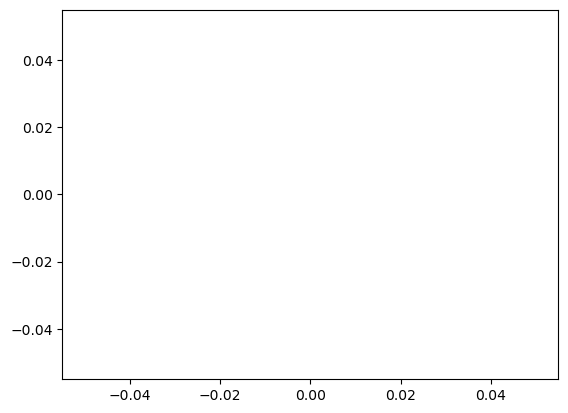

In [40]:
#print(saveposteriors.shape)
#print(save_i.shape)
#print(save_j.shape)
print(xv.shape, yv.shape)


lp = saveposteriors.sum(axis=0)
print(lp.shape)
plt.plot(x, np.exp(-(lp-lp.min())))




(100,)


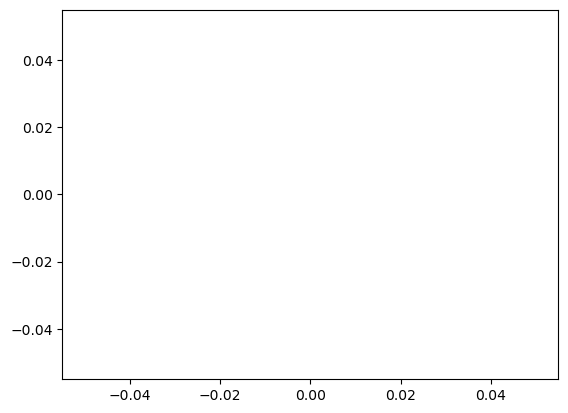

In [41]:
lp1 = saveposteriors.sum(axis=0)
print(lp1.shape)
plt.plot(y, np.exp(-(lp1-lp1.min())))


Text(0.5, 1.0, 'Simplest default with labels')

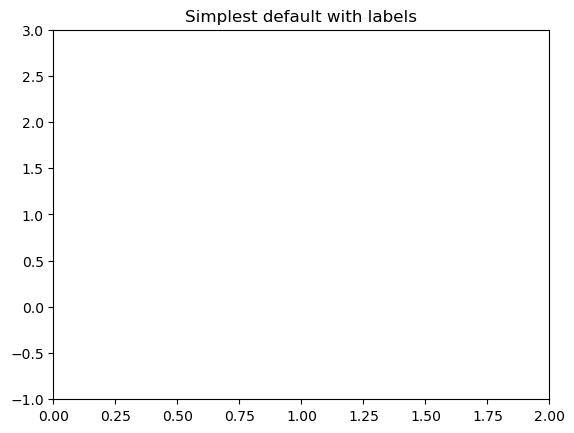

In [42]:
fig, ax = plt.subplots()
#CS = ax.contour(xv, yv, saveposteriors)
CS = ax.contour(xv, yv, np.exp(-(saveposteriors - saveposteriors.min())))
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Simplest default with labels')

## Method 3

In [116]:
saveposteriors = []
save_i = []
save_j = []

nx, ny = (100, 100)

x = np.linspace(0, 2, nx) # omega_m
y = np.linspace(0, 2, ny)  # omega_lambda

xv, yv = np.meshgrid(x, y, indexing='ij')

saveposteriors = np.zeros((nx, ny))

z = np.linspace(0, 2, 1000)
z0 = np.delete(z, 0)
print(z0.shape)

z_array = df['redshift'].to_numpy()
mag_array =  df['magnitude'].to_numpy()
mag_err = df['error_magnitude'].to_numpy()


'''
model1 = distance_modulus(z, xv, yv)
func_model1 = interp1d(z0, model1)
model2 = func_model1(z_array)
post = chi_square(model2, mag_array, mag_err)

for l in post:
    if l == float('inf') or l == float('nan') or l == float("-inf"):
        l = 0
    else:
        k = k + l
        #print(k)
        saveposteriors = k#post.sum()

'''


for i in range(nx):
    for j in range(ny):
        print(xv[i,j], '  ', yv[i,j])
        model1 = distance_modulus(z, xv[i, j], yv[i, j])
        #print(model1.shape)
        func_model1 = interp1d(z0, model1)
        #print(z0.shape)
        model2 = func_model1(z_array)
        post = chi_square(model2, mag_array, mag_err)
        k = 0
        for l in post:
            if l == float('inf') or l == float('nan') or l == float("-inf"):
                l = 0
            else:
                k = k + l
                #print(k)
        saveposteriors[i][j] = k#post.sum()

        

#saveposteriors = np.array(saveposteriors)

print(saveposteriors)
lw = 2  # Line widths throughout the plot
fsz = 16  # Font size throughout the plot

# Square figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')

# Contour and labels
cs = ax.contour(x, y, saveposteriors, colors='k', linewidths=lw)
plt.clabel(cs, fontsize=fsz)


(999,)
0.0    0.0
0.0    0.020202020202020204
0.0    0.04040404040404041
0.0    0.06060606060606061
0.0    0.08080808080808081
0.0    0.10101010101010102
0.0    0.12121212121212122
0.0    0.14141414141414144
0.0    0.16161616161616163
0.0    0.18181818181818182
0.0    0.20202020202020204
0.0    0.22222222222222224
0.0    0.24242424242424243
0.0    0.26262626262626265
0.0    0.2828282828282829
0.0    0.30303030303030304
0.0    0.32323232323232326
0.0    0.3434343434343435
0.0    0.36363636363636365
0.0    0.38383838383838387
0.0    0.4040404040404041
0.0    0.42424242424242425
0.0    0.4444444444444445
0.0    0.4646464646464647
0.0    0.48484848484848486
0.0    0.5050505050505051
0.0    0.5252525252525253
0.0    0.5454545454545455
0.0    0.5656565656565657
0.0    0.5858585858585859
0.0    0.6060606060606061
0.0    0.6262626262626263
0.0    0.6464646464646465
0.0    0.6666666666666667
0.0    0.686868686868687
0.0    0.7070707070707072
0.0    0.7272727272727273
0.0    0.7474747474747475
0

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_23561/2867433352.py:31: RuntimeWarning: invalid value encountered in sqrt
  d_M = d_H * (1/np.sqrt(omega_k)) * np.sin((np.sqrt(omega_k) * d_C) / d_H)


ValueError: x and y arrays must be equal in length along interpolation axis.

In [69]:
model1 = model(z_array, 0.2, 0.3)
print(model1)
post = chi_square(model1, mag_array, mag_err)
#print(z_array)

[       -inf 34.86466673 35.14075243 36.31641117 35.88104887 37.09968861
 36.72985815         nan 33.87601448 34.31686269 32.69002178         nan
 37.55731376         nan 36.54584137         nan 34.85191224 29.79683507
         nan         nan 29.71828362         nan         nan         nan
 34.74976025         nan         nan 32.47459998 34.73572359         nan
         nan 38.19449183 32.56141034         nan         nan         nan
         nan         nan 32.68995967         nan         nan 30.59552891
         nan         nan 35.21137173         nan         nan         nan
 29.01916208         nan         nan 35.27085111 38.84976753 33.3488143
 38.18646684 38.62109433 38.32083129 36.72232355 35.57952755 30.09252045
 33.60285569         nan         nan         nan 32.61786603         nan
 30.34602894         nan         nan         nan 29.4721733          nan
         nan 32.07564969 32.56063399         nan 27.45674853         nan
         nan         nan         nan 31.76493512 35.

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_23561/3215356461.py:4: RuntimeWarning: divide by zero encountered in log10
  dis_mod = 5 * np.log10(dl) + 25
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_23561/3215356461.py:4: RuntimeWarning: invalid value encountered in log10
  dis_mod = 5 * np.log10(dl) + 25


In [44]:
lw = 2  # Line widths throughout the plot
fsz = 16  # Font size throughout the plot

# Define X and Y labels
x = numpy.arange(50) + 100.0
y = numpy.arange(50) + 10.0

# Square figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')

# Contour and labels
cs = ax.contour(x, y, data, colors='k', linewidths=lw)
plt.clabel(cs, fontsize=fsz)

# Axes labels
ax.set_xlabel('x axis', fontsize=fsz)
ax.set_ylabel('y axis', fontsize=fsz)

# Make tick lines thicker
for l in ax.get_xticklines():
    l.set_markeredgewidth(lw)
for l in ax.get_yticklines():
    l.set_markeredgewidth(lw)

# Make axis label larger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fsz)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fsz)

# Make figure box thicker
for s in ax.spines.values():
    s.set_linewidth(lw)

plt.show()

# Centered on page by default
if outplot:
    plt.savefig(outplot)
    print(outplot, 'created')

NameError: name 'numpy' is not defined

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [280 lines of output]
      /Users/simran/anaconda3/lib/python3.11/site-packages/setuptools/dist.py:745: SetuptoolsDeprecationWarning: Invalid dash-separated options
      !!
      
              ********************************************************************************
              Usage of dash-separated 'author-email' will not be supported in future
              versions. Please use the underscore name 'author_email' instead.
      
              This deprecation is overdue, please update your project and remove deprecated
              calls to avoid build errors in the future.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              *******************************